In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp

def image_show(image, nrows=1, ncols=1, cmap='gray'): 

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))

    ax.imshow(image, cmap='gray')

    ax.axis('on')
    return fig, ax

In [3]:
import sys
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"

device = "cuda"
model_type = "default"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)



Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [4]:
predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=20,)

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


In [6]:


img=cv2.imread('00297.png')
imgg, box=find_tee(img)
#img=cv2.imread('0.png')

"""predictor.set_image(img)


masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    #box=box[None, :],
    multimask_output=False,
)



print(len(masks))

plt.figure(figsize=(20,20))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(box, plt.gca())
plt.axis('off')
plt.show()"""

masks = mask_generator.generate(img)



In [7]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(masks)
show_box(box,plt.gca())
plt.axis('off')
plt.show()

KeyboardInterrupt: 

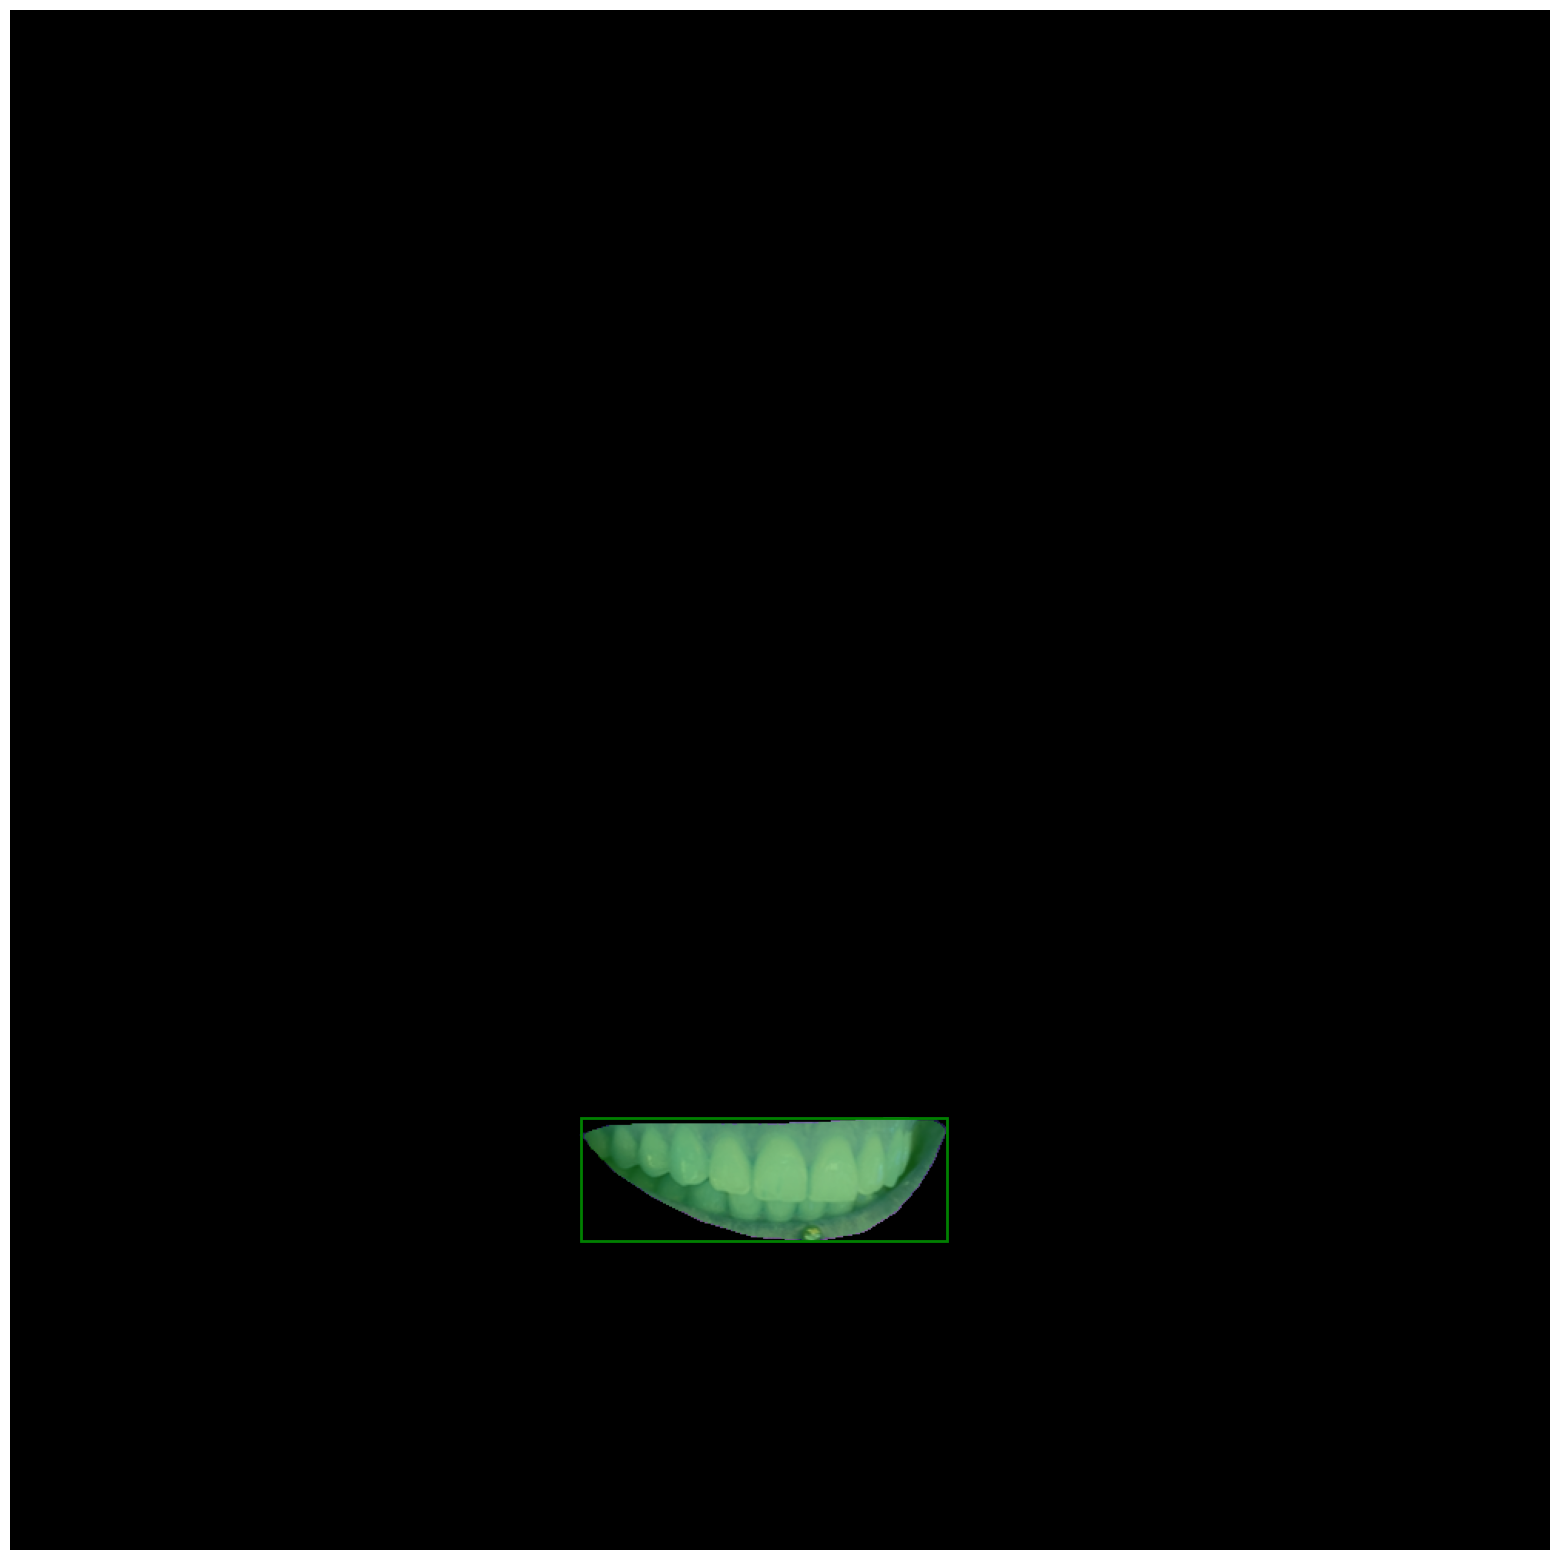

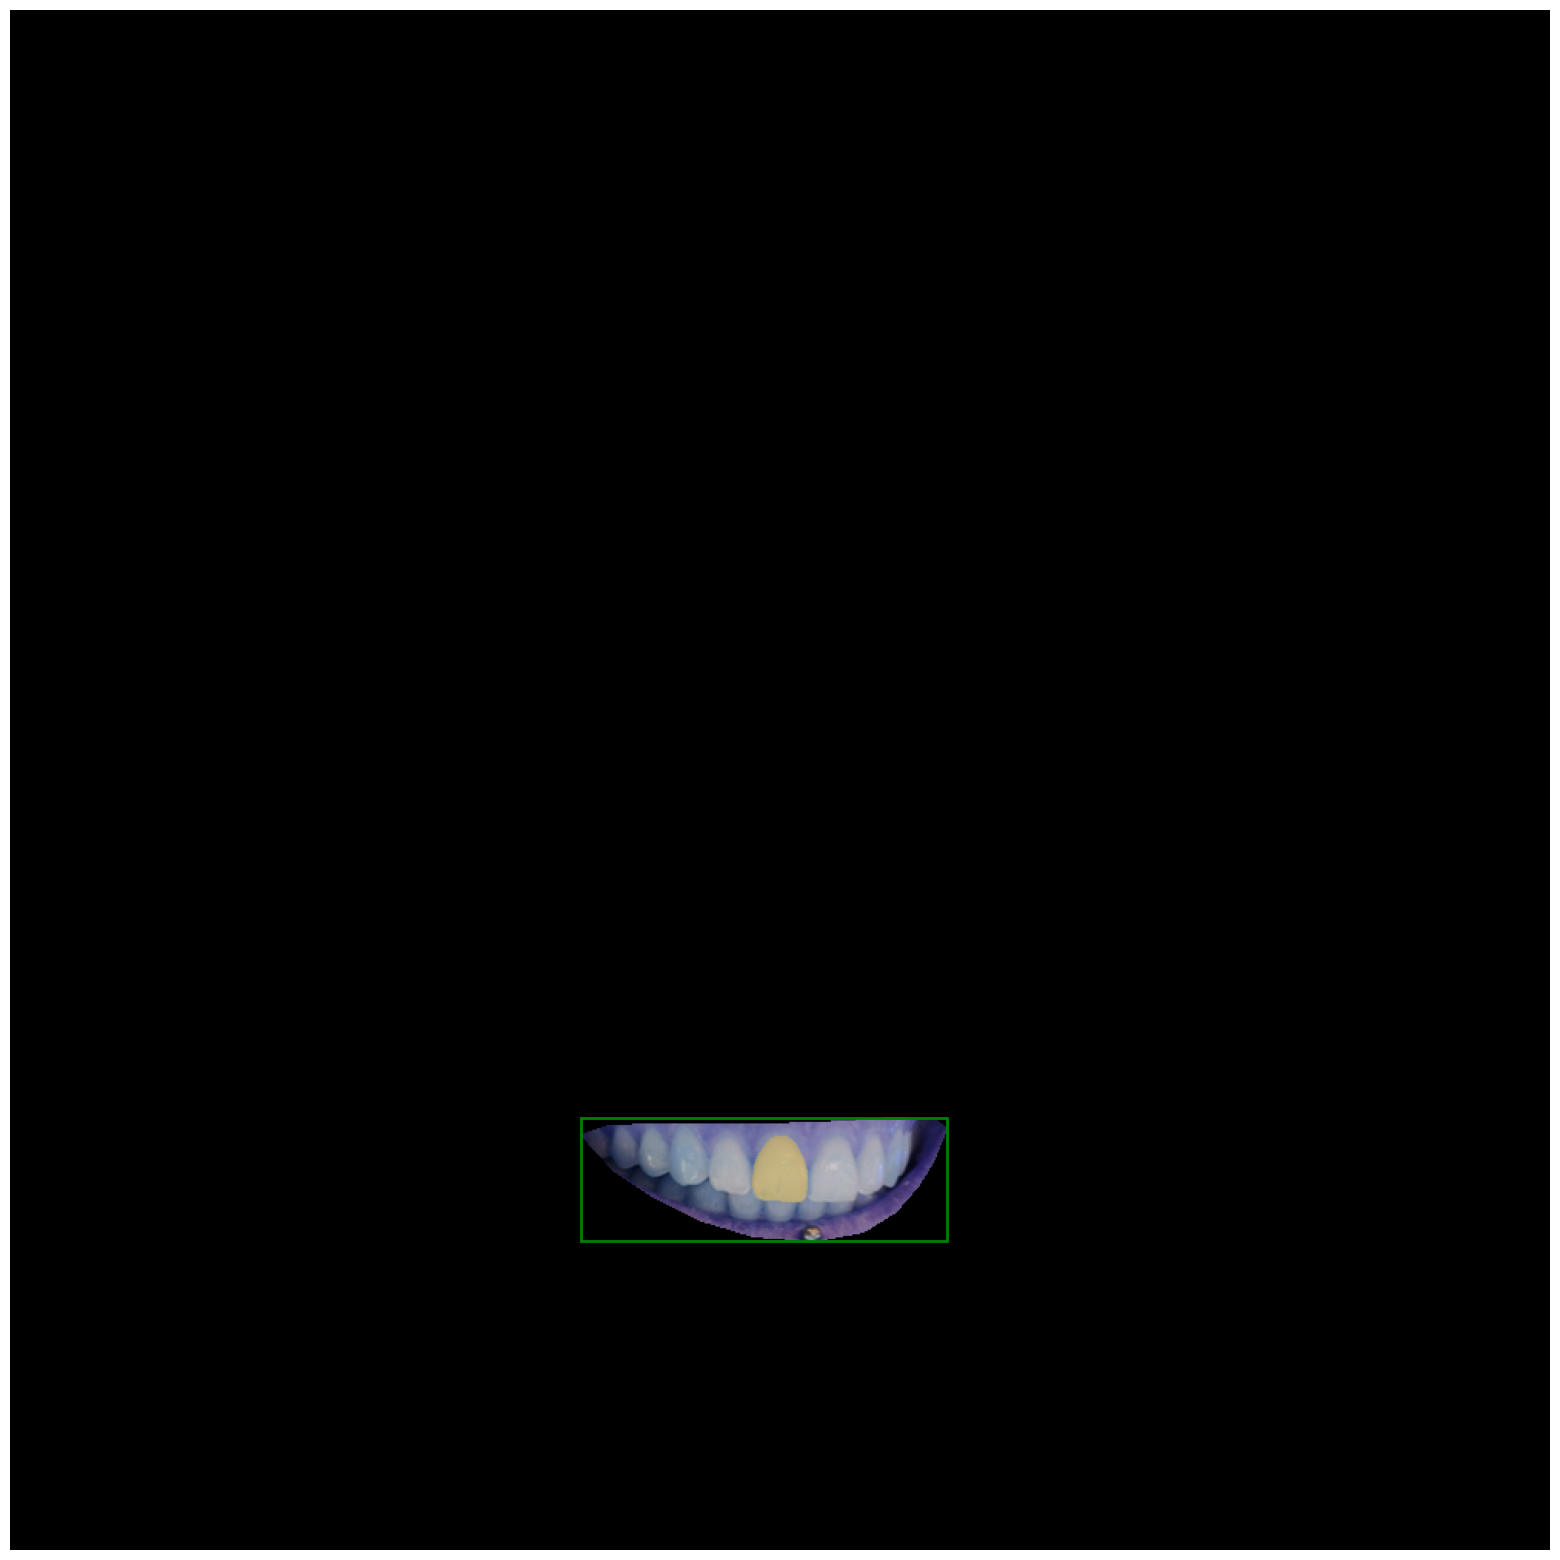

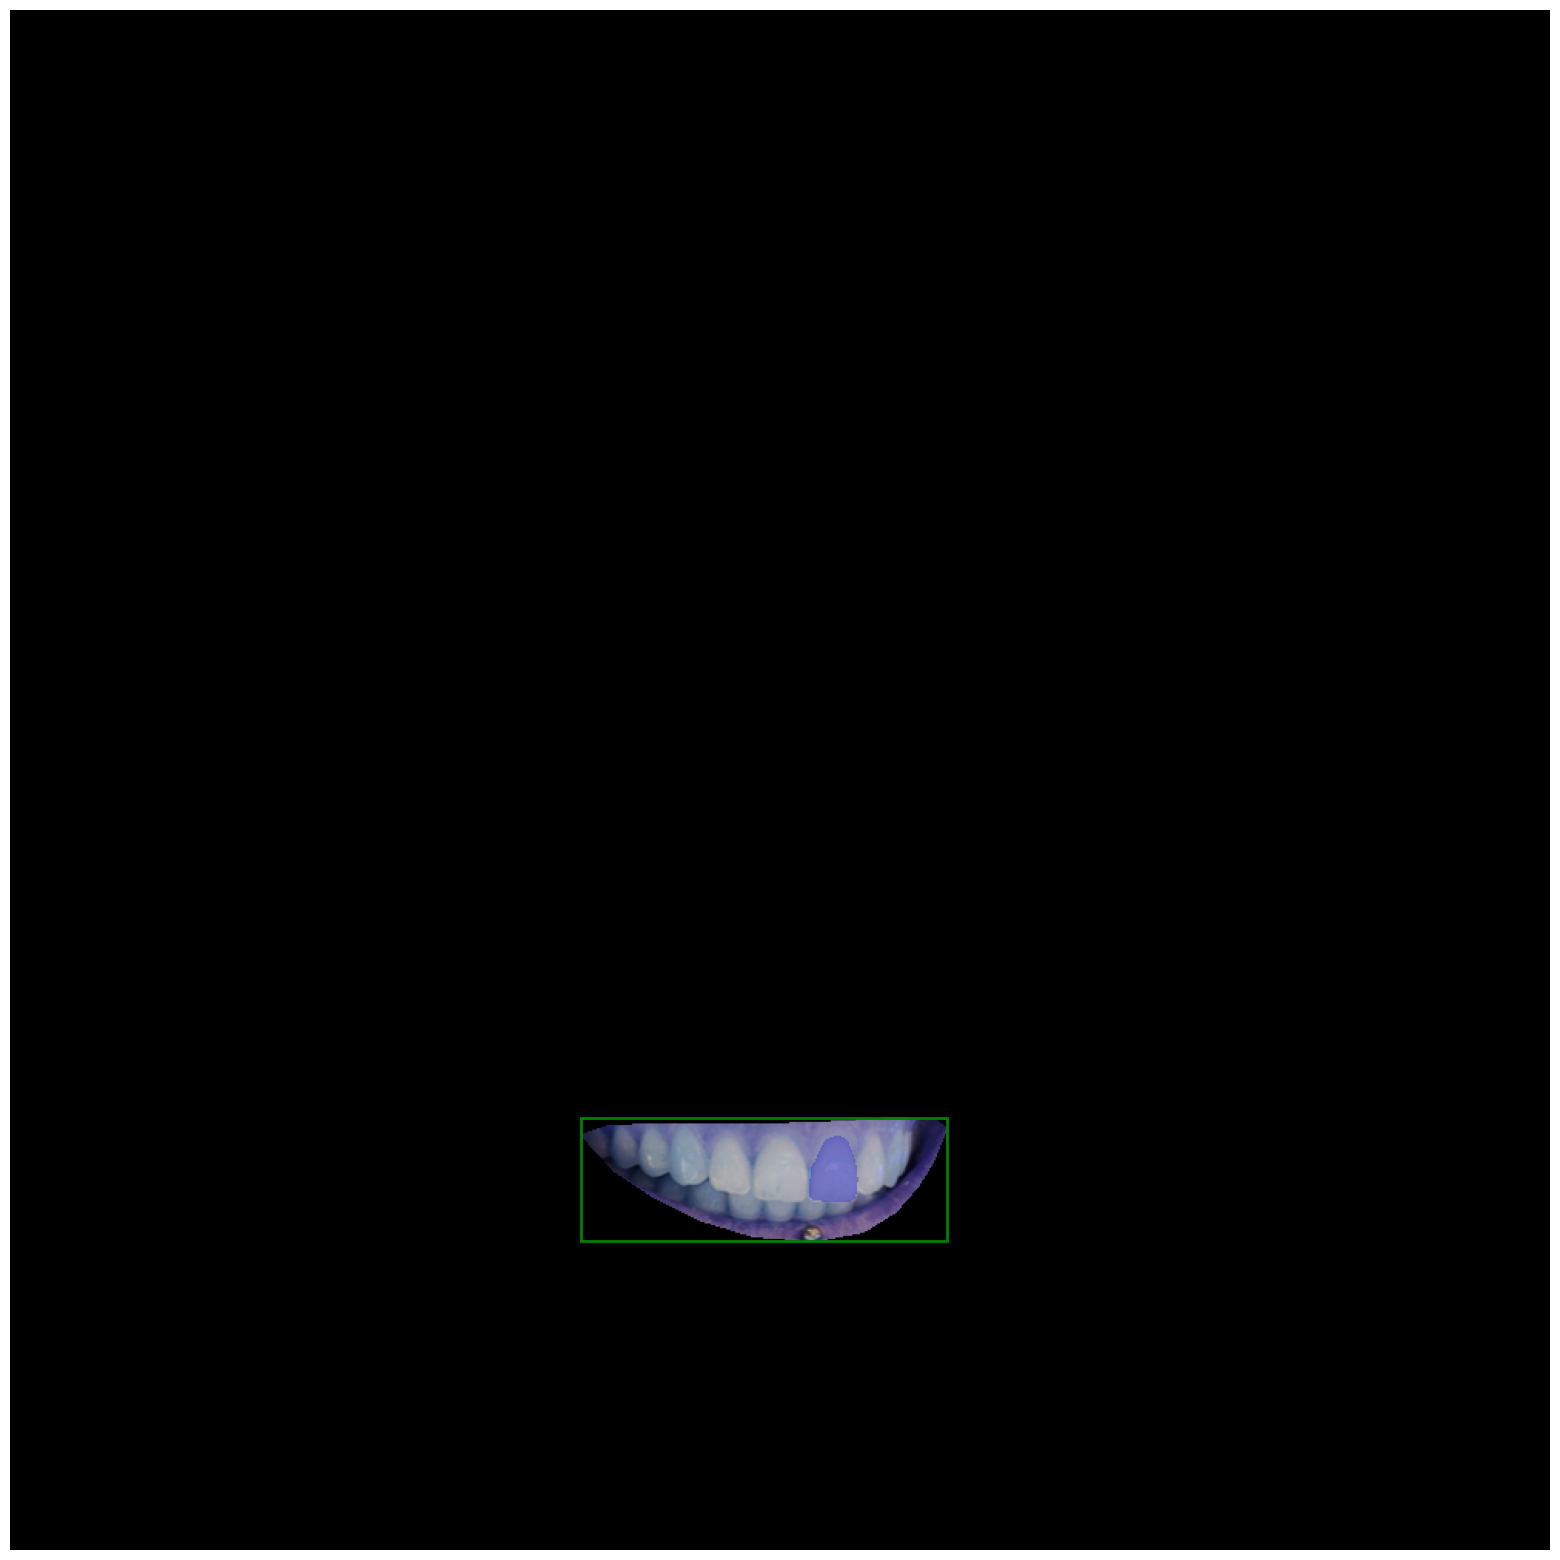

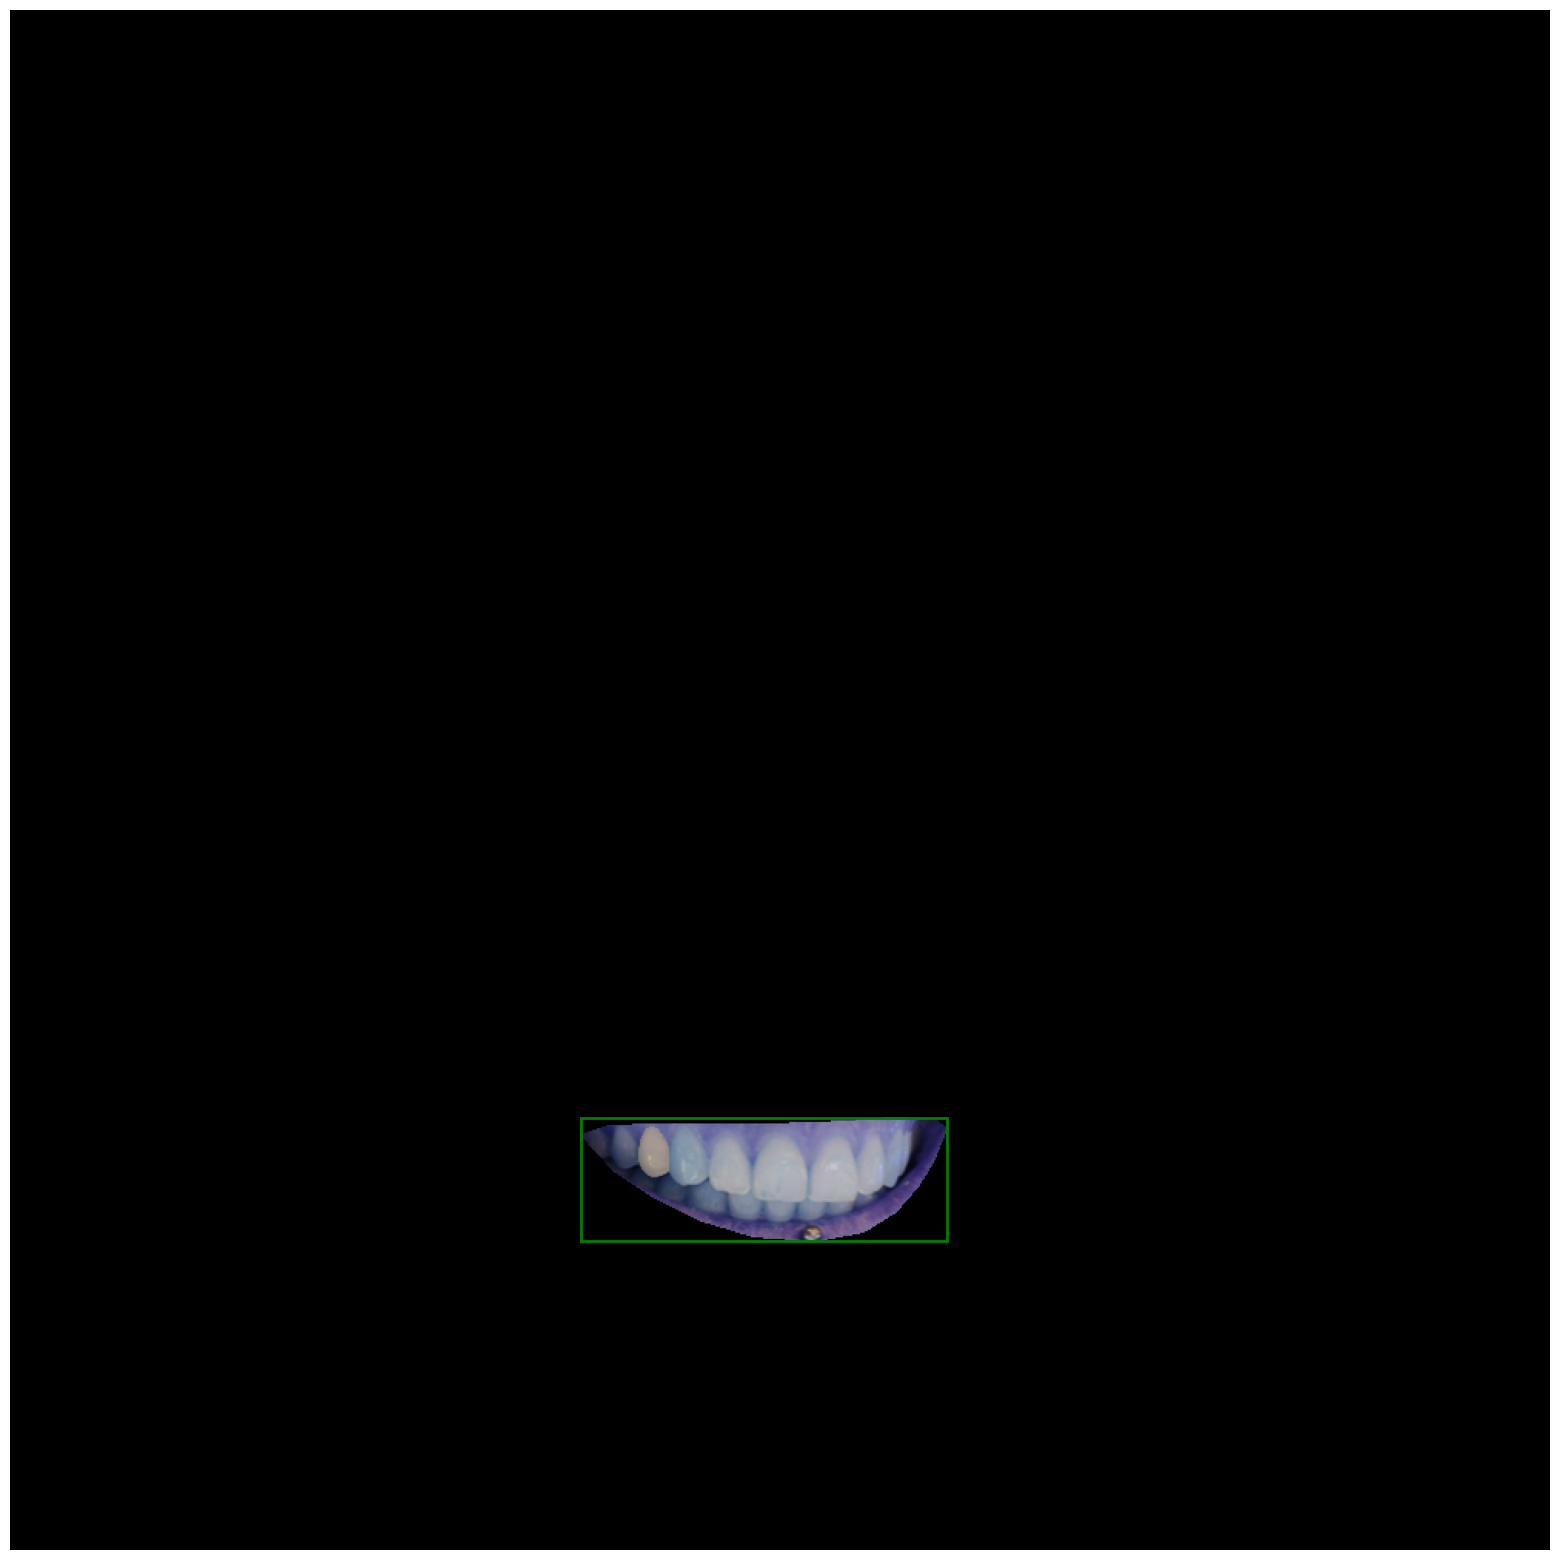

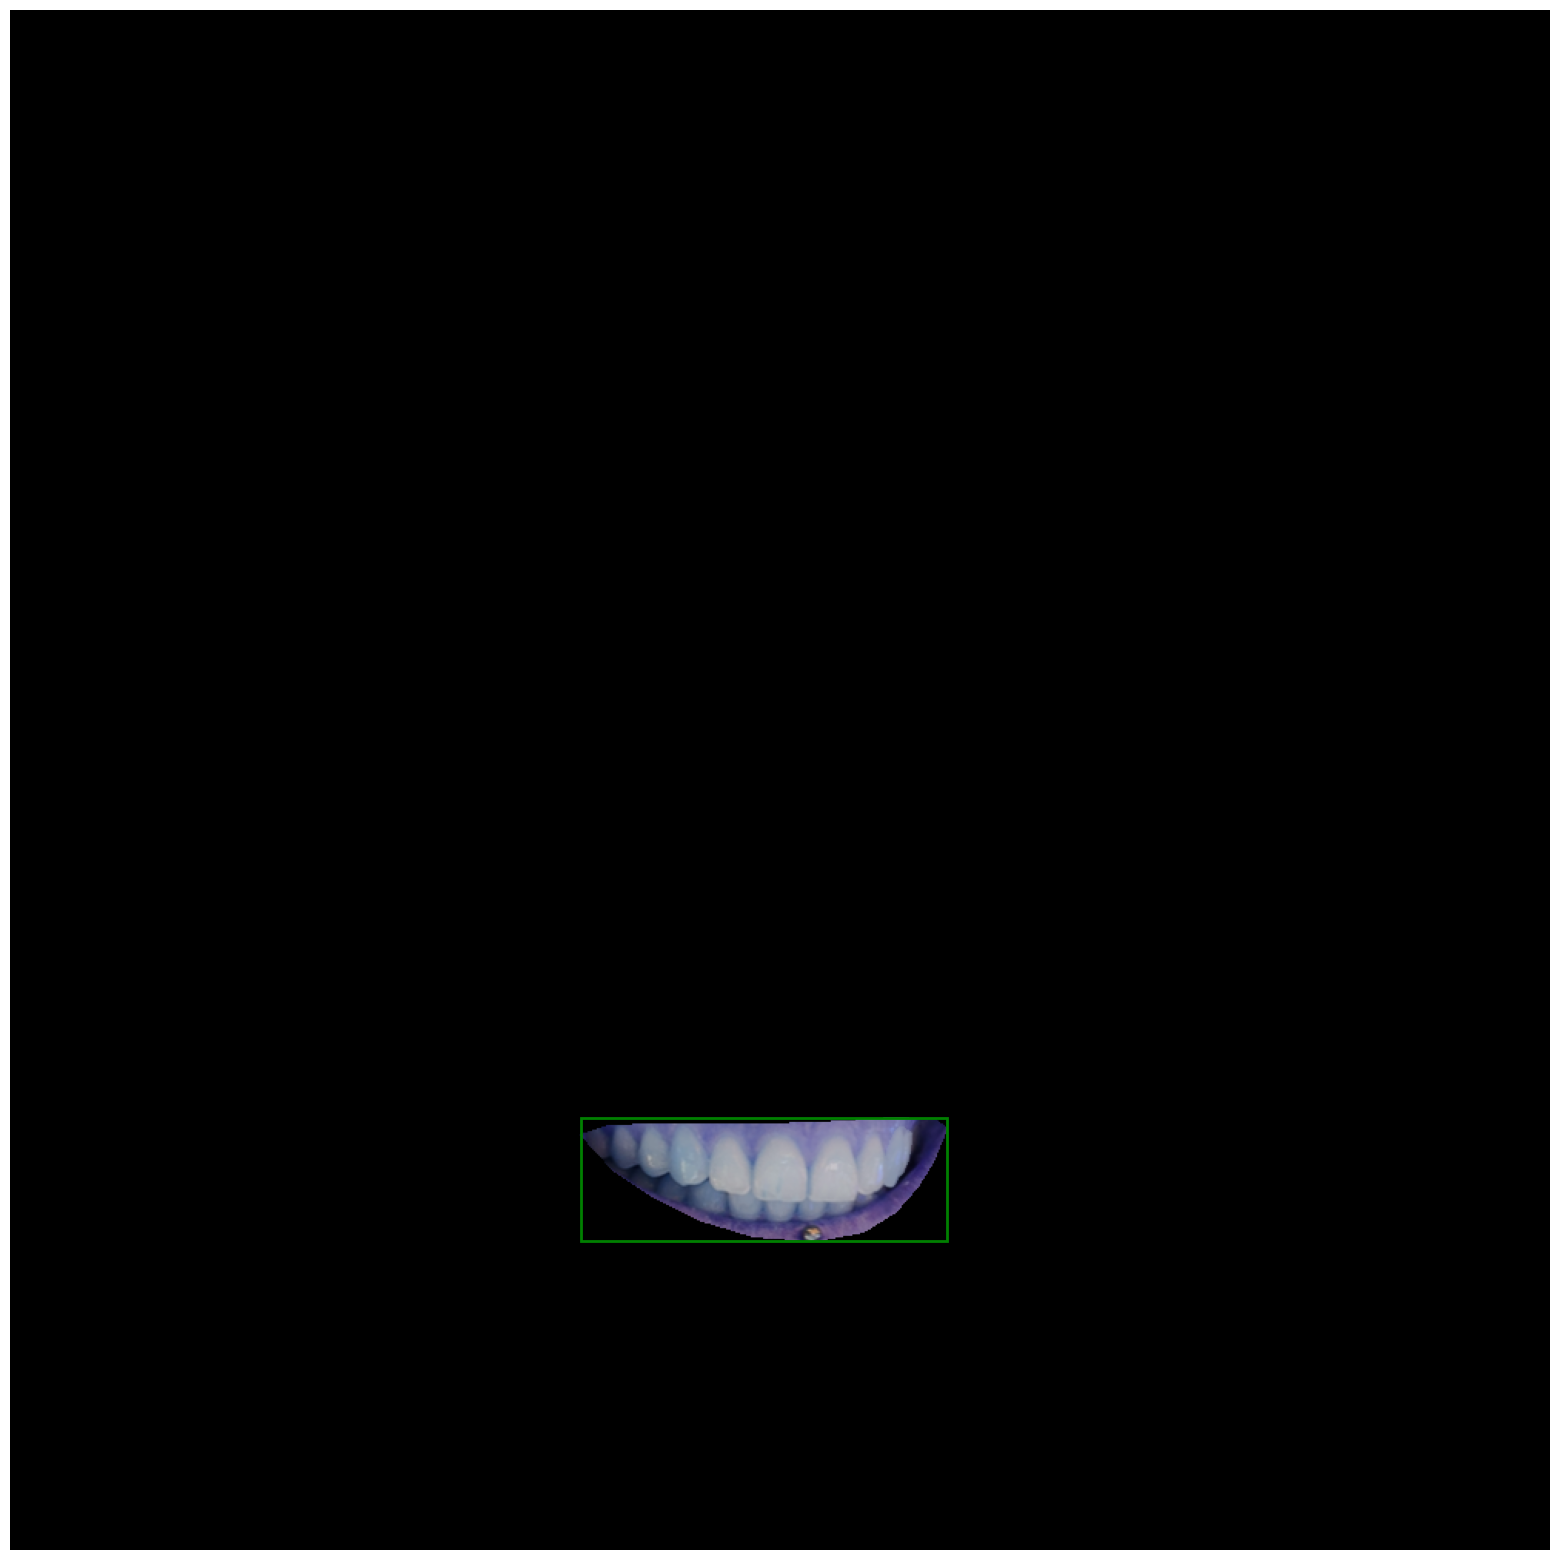

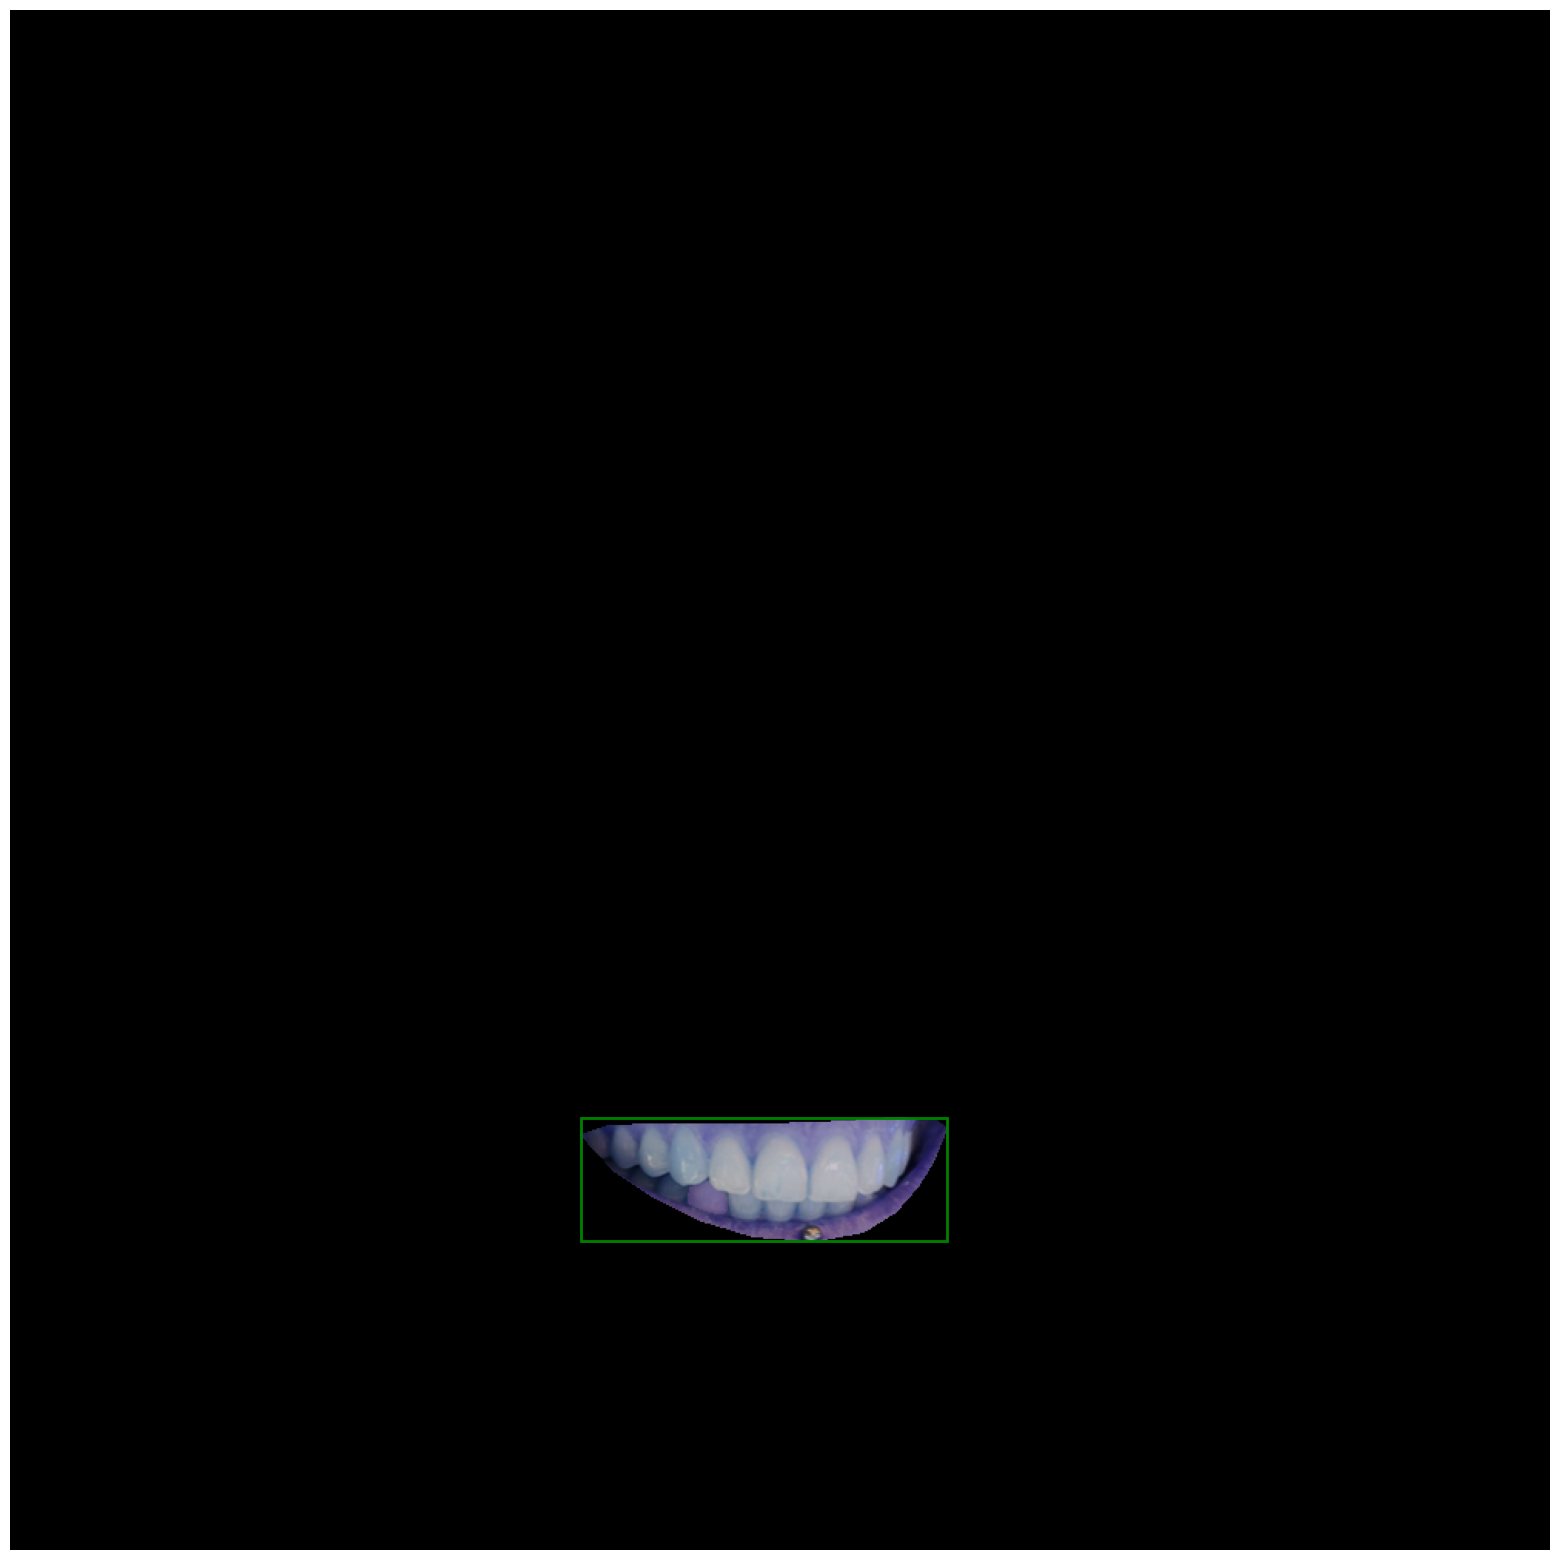

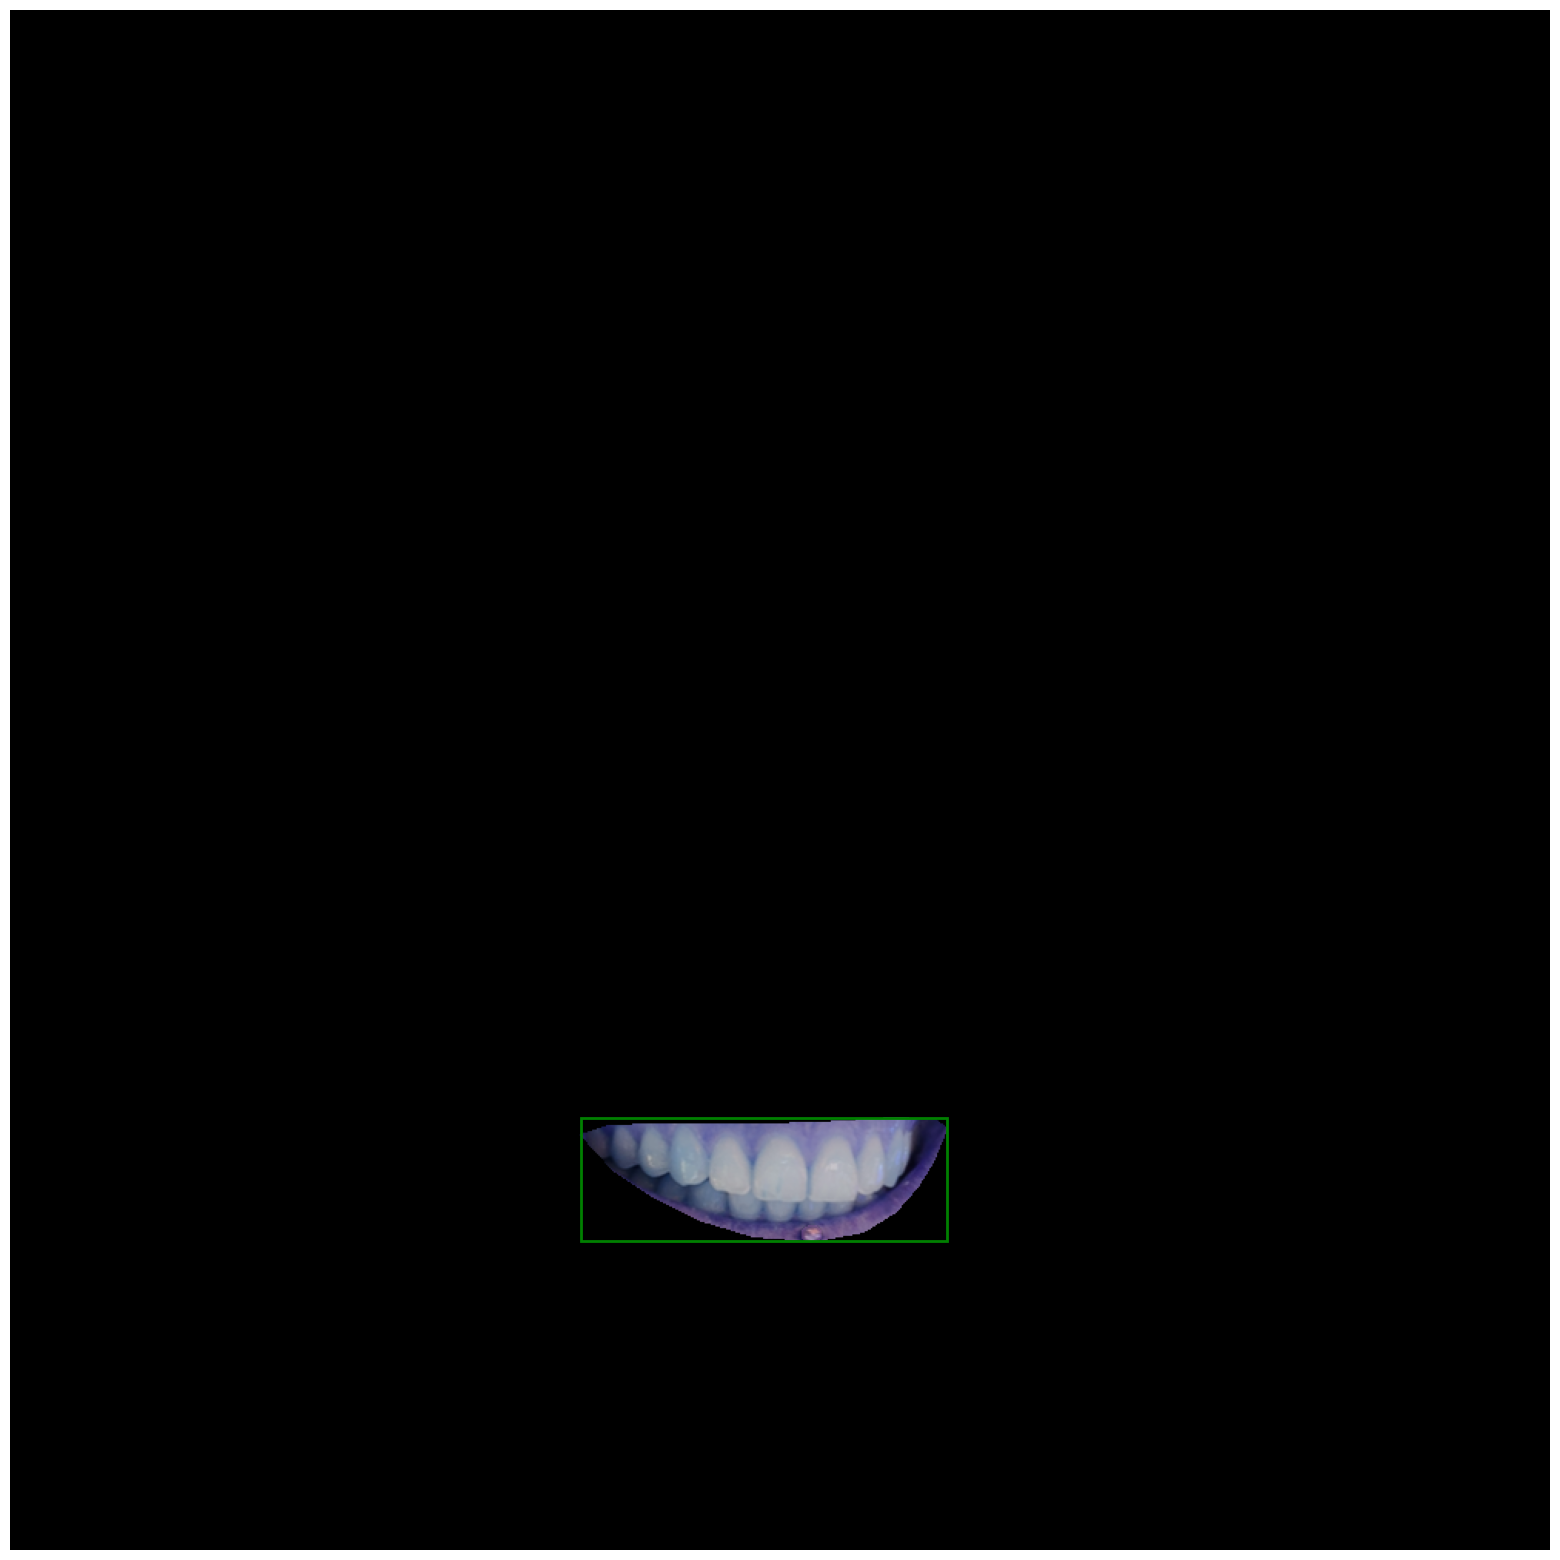

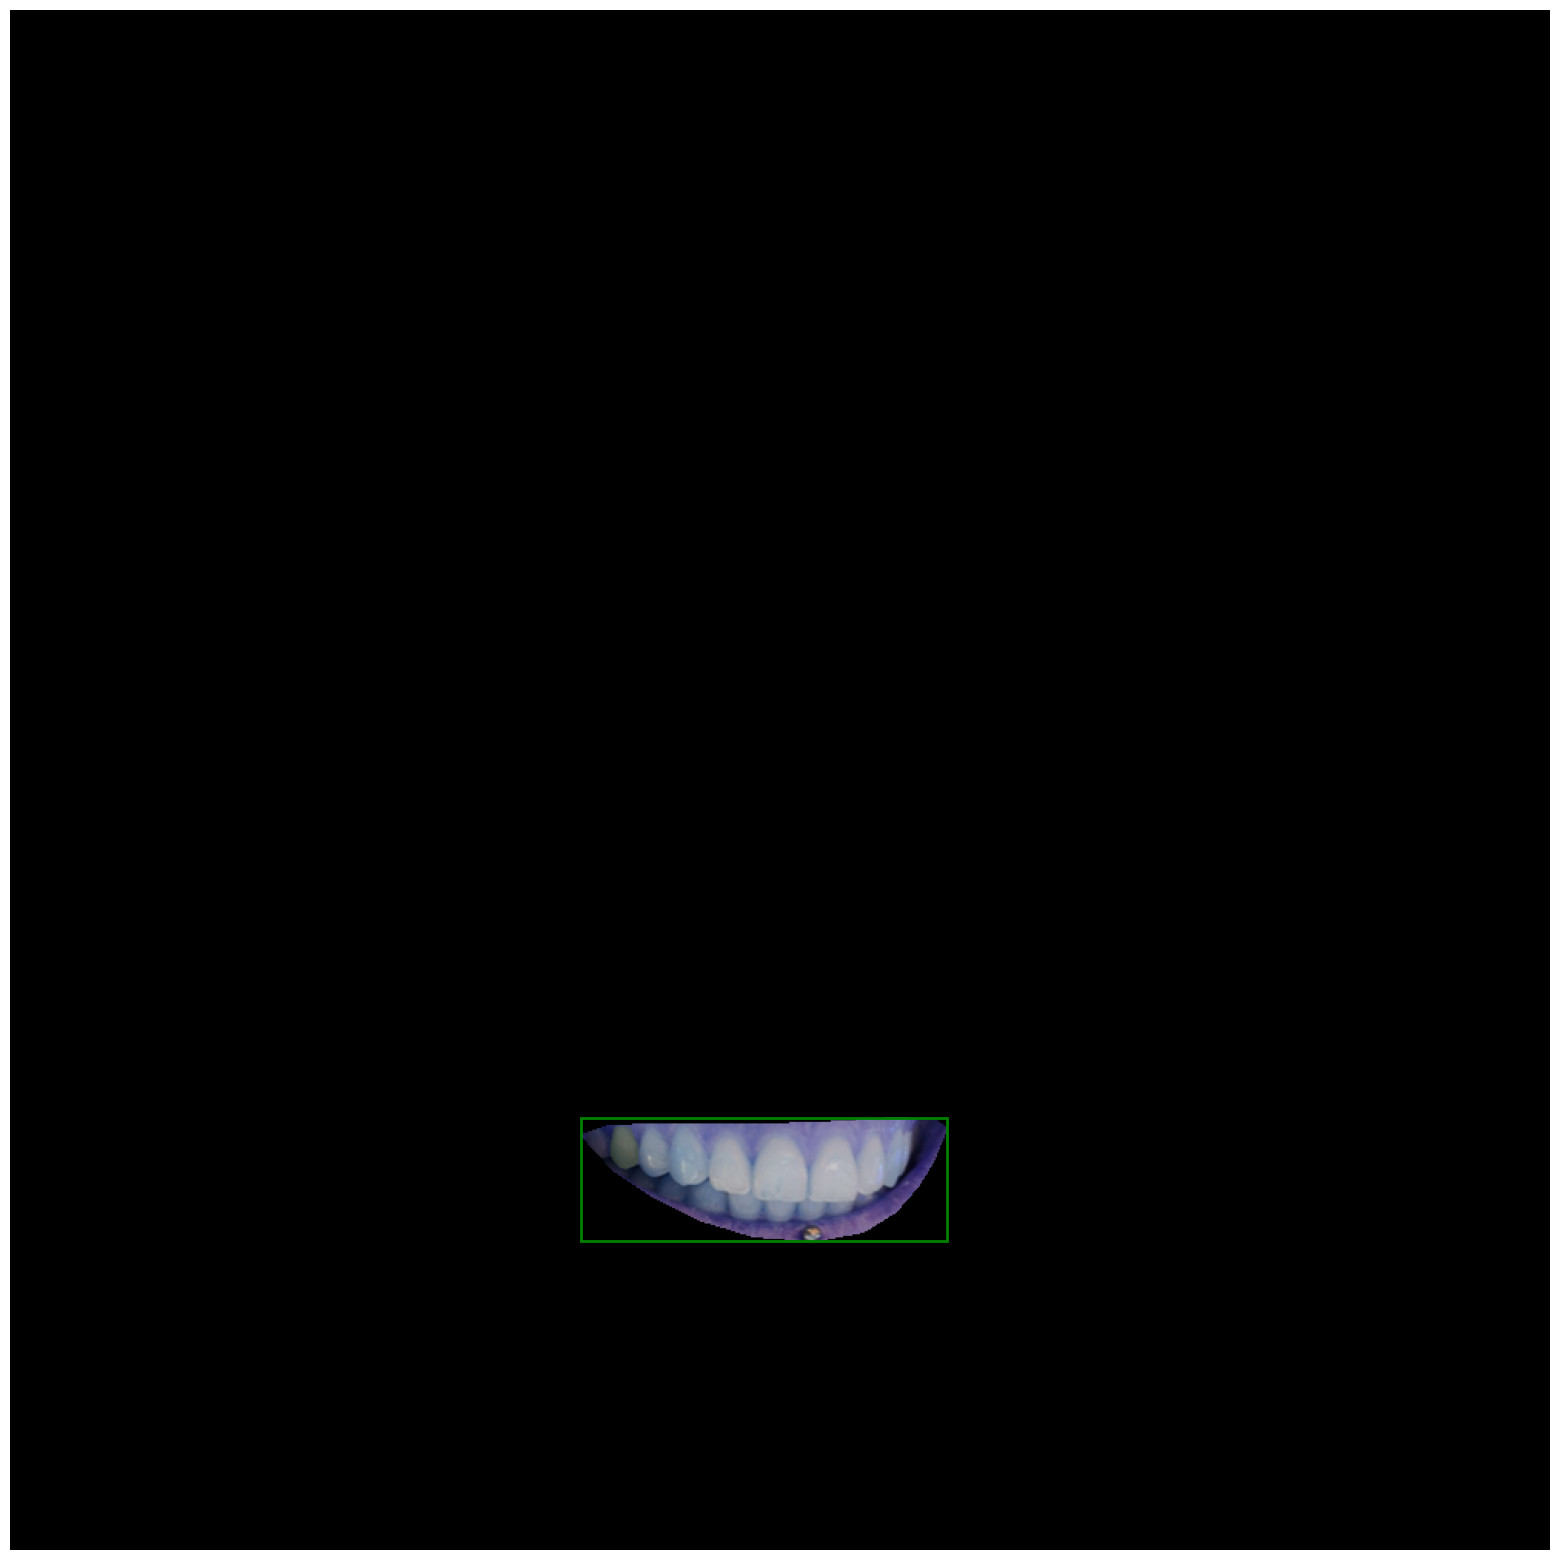

In [56]:
def boxAinB(a,b):
    return a[0]>=b[0] and a[2]<=b[2] and a[1]>=b[1] and a[3]<=b[3]

mask_in=[]
for mask in masks:
    if boxAinB(mask['bbox'],box):
        mask_in.append(mask)

for mask in mask_in:
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    show_anns([mask])
    show_box(box,plt.gca())
    plt.axis('off')
    plt.show()





In [57]:
len(mask_in)

8

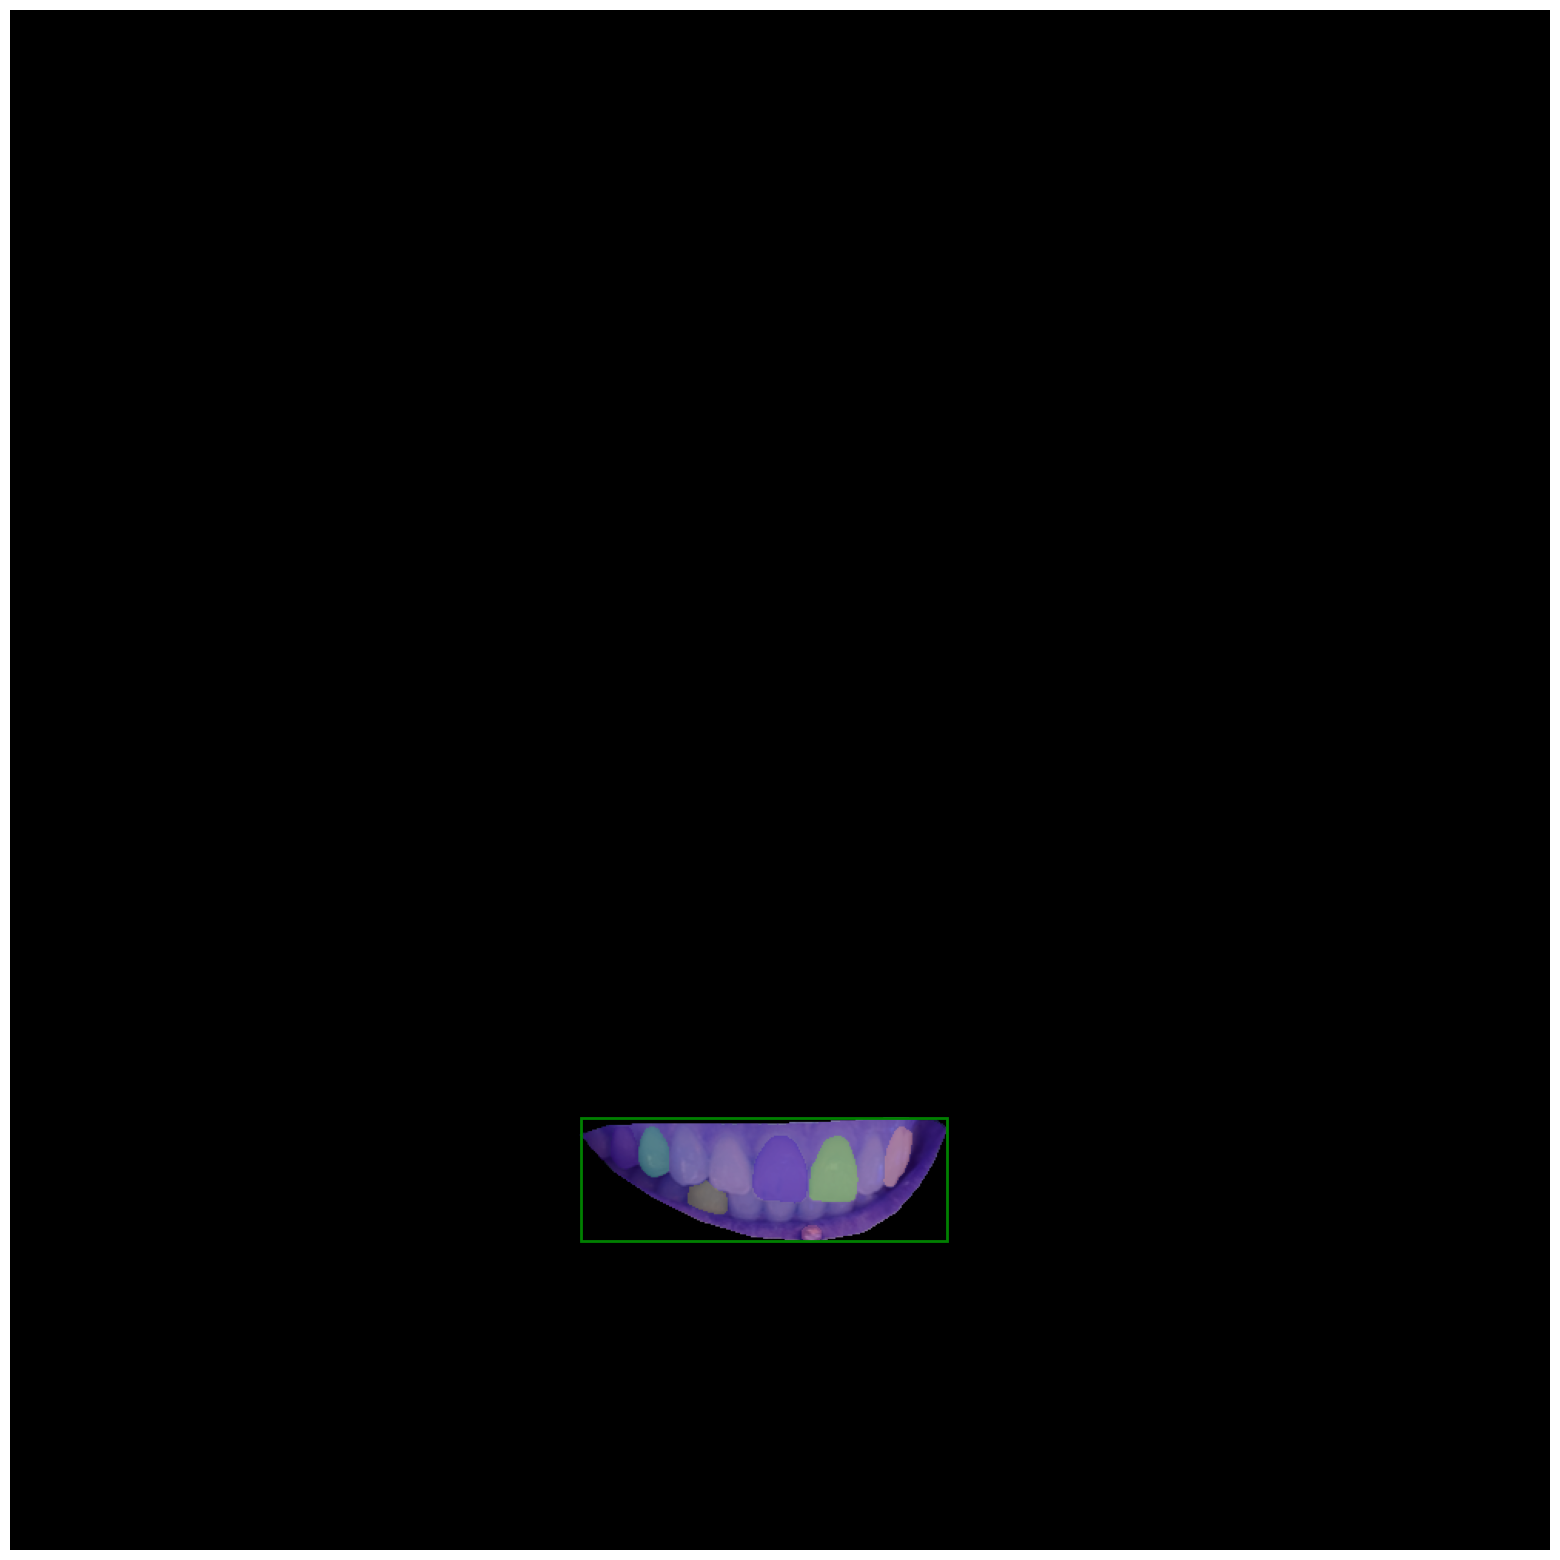

In [58]:
plt.figure(figsize=(20,20))
plt.imshow(img)
show_anns(mask_in)
show_box(box,plt.gca())
plt.axis('off')
plt.show()

(<Figure size 1500x1500 with 1 Axes>, <AxesSubplot: >)

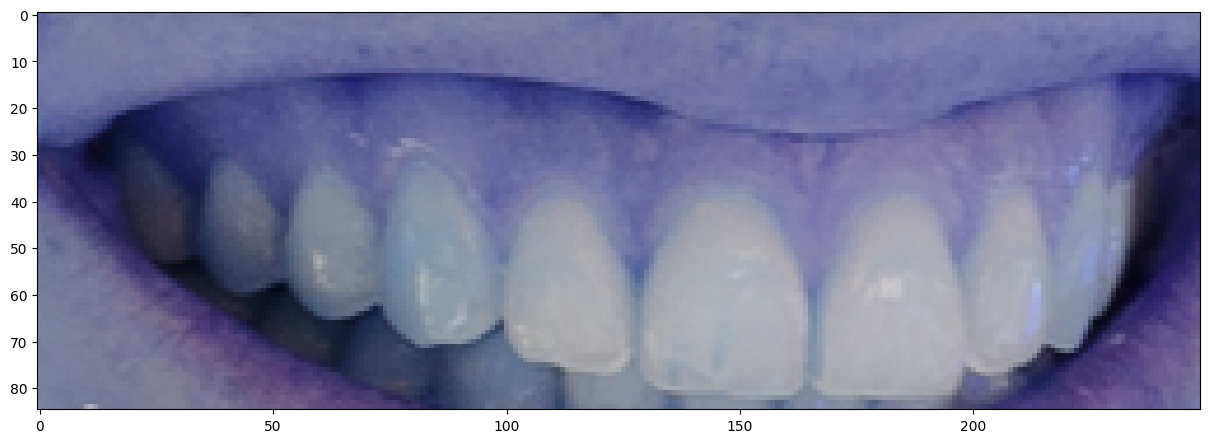

In [8]:
crop_img = img[box[1]:box[3],box[0]:box[2]]
image_show(crop_img)
